In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from datetime import datetime

# Import Data and Standard Scale

In [2]:
data = pd.read_csv("CL_dnn_data.csv")
data.count()

<Close_diff_y>     2228
<Close_diff>       2228
<Open_diff>        2228
<High_diff>        2228
<Low_diff>         2228
 <Volume>          2228
 <FastAvg_diff>    2228
 <MedAvg_diff>     2228
 <SlowAvg_diff>    2228
 <Red 5>           2228
 <Yellow 5>        2228
 <Blue 5>          2228
 <DBlue 5>         2228
 <Red 1>           2228
 <Yellow 1>        2228
 <Blue 1>          2228
 <DBlue 1>         2228
 <SlowK>           2228
 <SlowD>           2228
dtype: int64

In [11]:
data_to_plot = data.loc[:, ["<Close_diff_y>"]]
data_to_plot = data_to_plot.as_matrix()

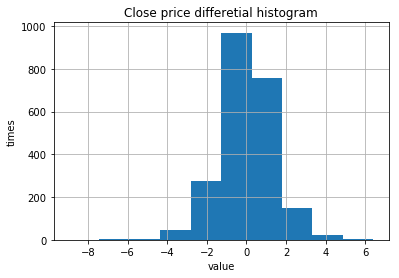

In [5]:
plt.hist(data_to_plot)
plt.title("Close price differetial histogram")
plt.xlabel("value")
plt.ylabel("times")
plt.grid(True)
plt.show()

In [6]:
data_train = data.iloc[0:2000]
data_test = data.iloc[2000:]

In [7]:
y_train = data_train.loc[:, ["<Close_diff_y>"]]
x_train_raw = data_train.drop("<Close_diff_y>", axis = 1)


y_test = data_test.loc[:, ["<Close_diff_y>"]]
x_test_raw = data_test.drop("<Close_diff_y>", axis = 1)

In [8]:
x_train_raw.describe()

,<Close_diff>,<Open_diff>,<High_diff>,<Low_diff>,<Volume>,<FastAvg_diff>,<MedAvg_diff>,<SlowAvg_diff>,<Red 5>,<Yellow 5>,<Blue 5>,<DBlue 5>,<Red 1>,<Yellow 1>,<Blue 1>,<DBlue 1>,<SlowK>,<SlowD>
count,2000.00000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.00781,-0.009020,-0.008930,-0.007760,2.428458e+05,-0.009350,-0.009670,-0.010445,-0.057720,-0.195240,-0.469265,0.003965,0.001355,0.005170,-0.025220,0.001280,51.594990,51.572320
std,1.39912,1.395431,1.162925,1.239757,1.189469e+05,0.678188,0.454326,0.322362,2.100776,5.273686,9.576264,4.601332,0.960603,2.270821,3.854396,2.197141,29.188785,28.361945
min,-8.97000,-9.020000,-7.000000,-10.230000,6.339000e+03,-3.730000,-2.010000,-1.170000,-6.780000,-12.670000,-22.460000,-15.400000,-4.060000,-7.840000,-12.680000,-10.240000,1.290000,2.420000
25%,-0.87000,-0.870000,-0.670000,-0.680000,1.657750e+05,-0.420000,-0.290000,-0.220000,-1.480000,-3.762500,-6.852500,-2.862500,-0.570000,-1.322500,-2.480000,-1.210000,23.612500,24.557500
50%,0.01000,0.010000,-0.050000,0.060000,2.184665e+05,0.010000,0.010000,0.010000,-0.320000,-0.415000,-0.855000,0.030000,-0.010000,-0.110000,-0.260000,-0.030000,53.930000,53.715000
75%,0.85250,0.832500,0.630000,0.700000,2.911875e+05,0.420000,0.290000,0.210000,1.140000,2.932500,4.762500,2.940000,0.530000,1.210000,2.182500,1.252500,78.162500,77.615000
max,6.41000,6.420000,4.510000,4.760000,1.075988e+06,2.760000,1.710000,1.060000,6.570000,19.070000,31.840000,13.530000,5.310000,9.490000,13.800000,8.360000,99.050000,98.700000


In [9]:
x_train_raw_mean = x_train_raw.mean()
x_train_raw_sd = x_train_raw.std()

In [10]:
x_train = (x_train_raw - x_train_raw_mean) / x_train_raw_sd
x_test = (x_test_raw - x_train_raw_mean) / x_train_raw_sd

# train and test data after standard scale

# Train the Model

In [12]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

def switch(x):
    return x * (1 / (1 + tf.exp(-x)))

In [13]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_log = "CL_dnn_tf_log"
logdir = "{}/run-{}/".format(root_log, now)

In [14]:
tf.reset_default_graph()
# make sure that no node been made twice

n_inputs = 18
n_hidden1 = 200
n_hidden2 = 150
n_hidden3 = 100
n_output = 1

batch_norm_momentum = 0.9

In [15]:
x = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
y = tf.placeholder(tf.float32, shape = (None), name = "Y")
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5
x_drop = tf.layers.dropout(x, dropout_rate, training = training)

he_init = tf.contrib.layers.variance_scaling_initializer()

In [16]:
with tf.name_scope("dnn"):
    batch_norm = partial(tf.layers.batch_normalization, training = training, momentum = batch_norm_momentum)
    dense_layer = partial(tf.layers.dense, kernel_initializer = he_init)
    
    hidden1 = dense_layer(x_drop, n_hidden1, name = "hidden1")
    bNorm1 = switch(batch_norm(hidden1))
    hidden1_drop = tf.layers.dropout(bNorm1,dropout_rate, training = training)
    
    hidden2 = dense_layer(hidden1_drop, n_hidden2, name = "hidden2")
    bNorm2 = switch(batch_norm(hidden2))
    hidden2_drop = tf.layers.dropout(bNorm2,dropout_rate, training = training)
    
    hidden3 = dense_layer(hidden2_drop, n_hidden3, activation = switch, kernel_initializer = he_init, name = "hidden3")
    bNorm3 = switch(batch_norm(hidden3))
    hidden3_drop = tf.layers.dropout(bNorm3,dropout_rate, training = training)
    
    output = tf.layers.dense(hidden3_drop, n_output, activation = None, name = "output")

注意上面 dense 裡前兩個參數的填寫方式

In [17]:
with tf.name_scope("MSE"):
    error = output - y
    mse = tf.reduce_mean(tf.square(error))

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(mse)

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

mse_summary = tf.summary.scalar('mse', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [21]:
n_epoch = 1000

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epoch):
        if epoch % 100 == 0:
            current_mse = mse_summary.eval(feed_dict={x: x_train, y: y_train})
            file_writer.add_summary(current_mse, epoch)
            
            print("Epoch", epoch, "MSE =", mse.eval(feed_dict={x: x_train, y: y_train}))
            
            save_path = saver.save(sess, "./CL_dnn_save/temple_sample_model.ckpt")
        
        sess.run([training_op, extra_update_ops], feed_dict={training: True, x: x_train, y: y_train})
        
   
    CL_dnn_train_mse = mse.eval(feed_dict={x: x_train, y: y_train})
    CL_dnn_train_error = error.eval(feed_dict={x: x_train, y: y_train})
    
    CL_dnn_test_mse = mse.eval(feed_dict={x: x_test, y: y_test})
    CL_dnn_test_error = error.eval(feed_dict={x: x_test, y: y_test})
    
    print("Final train mse = ", CL_dnn_train_mse)
    print("Final test mse = ", CL_dnn_test_mse)

    final_save_path = saver.save(sess, "./CL_dnn_save/final_sample_model.ckpt")

Epoch 0 MSE = 2.64127
Epoch 100 MSE = 1.94588
Epoch 200 MSE = 1.93888
Epoch 300 MSE = 1.93317
Epoch 400 MSE = 1.92169
Epoch 500 MSE = 1.91976
Epoch 600 MSE = 1.91211
Epoch 700 MSE = 1.90151
Epoch 800 MSE = 1.90434
Epoch 900 MSE = 1.89635
Final train mse =  1.90066
Final test mse =  0.640801


In [22]:
print(CL_dnn_train_error.std())
print(CL_dnn_test_error.std())

1.37739
0.795958


In [23]:
[variable.name for variable in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'hidden3/kernel:0',
 'hidden3/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0',
 'output/kernel:0',
 'output/bias:0',
 'train/beta1_power:0',
 'train/beta2_power:0',
 'hidden1/kernel/Adam:0',
 'hidden1/kernel/Adam_1:0',
 'hidden1/bias/Adam:0',
 'hidden1/bias/Adam_1:0',
 'batch_normalization/beta/Adam:0',
 'batch_normalization/beta/Adam_1:0',
 'batch_normalization/gamma/Adam:0',
 'batch_normalization/gamma/Adam_1:0',
 'hidden2/kernel/Adam:0',
 'hidden2/kernel/Adam_1:0',
 'hidden2/bias/Adam:0',
 'hidden2/bias/Ad

In [ ]:
**** Using trained network: ****

**** reuse the construct phase but change the excution phase ****

x_to_predict = ......

with tf.Session() as sess:
    saver.restore(sess, "./CL_dnn_save/final_sample_model.ckpt")
    y_predict = output.eval(feed_dict={x: x_to_predict})
    print(y_predict)